In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import vocModel.nntools as nt
import vocData as voc
import vocModel
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = 'cpu'

cuda


In [3]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
lr = 1e-3
batch_size = 8

In [4]:
def voc_data_loader():
    dataset = voc.VOCDetection(dataset_root_dir,  image_set = 'trainval')
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.1
    test_split = 0.1
    val_split = int(np.floor(validation_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))

    np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[val_split+test_split:],\
    indices[:val_split], indices[val_split:val_split+test_split]

    print (len(train_indices) + len(val_indices) + len(test_indices))
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler =  SubsetRandomSampler(test_indices)
    # Define data loaders
    print (batch_size)
    train_loader = td.DataLoader(dataset, batch_size=batch_size, \
                                 sampler=train_sampler,\
                                 drop_last=True, pin_memory=True)

    val_loader = td.DataLoader(dataset, batch_size=batch_size,\
                               sampler=valid_sampler, \
                               drop_last=True, pin_memory=True)

    test_loader = td.DataLoader(dataset, batch_size=1,\
                               sampler=test_sampler, \
                               drop_last=False, pin_memory=False)

    return train_loader, val_loader, test_loader


In [5]:
train_loader, val_loader, test_loader = voc_data_loader()
print ("Dataset is divided into train :{}, val : {}, test :{} ".format(len(train_loader), len(val_loader), len(test_loader)))


11540
8
Dataset is divided into train :1154, val : 144, test :1154 


In [6]:
# net = vocModel.YoloNet(7, 2, 20, 5,0.5)
net = vocModel.YoloNet_res(7, 2, 20, 5,0.5)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay = 5*1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, train_loader, val_loader, optimizer, stats_manager,batch_size=batch_size,
                     output_dir="data/resnet_3", perform_validation_during_training=True)

In [7]:
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']

In [8]:
def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image

In [50]:
def from_target_to_bndboxes(target):

    target_bboxes =  target.view(-1, 30)
    object_mask = target_bboxes[:,4] >0    
    
    wh= torch.pow(target_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (target_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0

    gt_bboxes =torch.cat((xy_min,  xy_max), dim = 1)

    gt_bboxes = gt_bboxes[object_mask].view(-1,4)
    gt_labels = torch.argmax(target_bboxes[:,10:], dim = 1)[object_mask].view(-1,1)

    return gt_bboxes, gt_labels

    
    
def from_predictino_to_bndboxes(output, conf_threshold):
    
    output_bboxes =  output.view(-1, 30)[:,:10]
    maxi = torch.eq(output_bboxes[:,[4,9]], torch.max(output_bboxes[:,[4,9]], dim =1)[0].unsqueeze(1)).view(-1)
    output_bboxes = output_bboxes.contiguous().view(-1,5)[maxi]
    output_class_prob, output_class_idx = torch.max(output.view(-1, 30)[:,10:], dim = 1)
    output_bboxes[:,4] *= output_class_prob

    # calculate bndboxes to xmin, ymin, xmax, ymax
    wh= torch.pow(output_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (output_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0
    output_bboxes[:,:4] = torch.cat((xy_min,  xy_max), dim = 1)

    # Choose high confidence bnd boxes
    conf_selected =output_bboxes[:,4] > conf_threshold
    output_bboxes = output_bboxes[conf_selected]
    output_class_idx = output_class_idx[conf_selected]
    
    return output_bboxes, output_class_idx

In [51]:
s = time.time()
predictions = []
for i in range(len(class_dict)):
    predictions.append([])
print (predictions)
gt_class_count = torch.zeros(len(class_dict)).view(1,-1).to(device)
print (gt_class_count)
test_iter = iter(test_loader)
print (len(test_loader))
net.eval()
with torch.no_grad():
#     for img, target in test_loader:
    for t in range(1):
        img, target= next(test_iter)
        img, target= img.to(device), target.to(device)
        C = 7
        B = 2
        w = 448
        h = 448
        cell_size = 1./C
        conf_threshold = 0.2
        ious_threshold = 0.3

        output = net.forward(img)
        output = output[0]
        target = target[0]
        
        # undo normailization
        img_mod = image_transform(img[0].to('cpu'))
        
        #gt variables
        gt_bboxes, gt_labels = from_target_to_bndboxes(target)
        
        #target to bndboxes
        temp =torch.zeros((gt_labels.size()[0], len(class_dict))).to(device)
        temp[torch.arange(gt_labels.size()[0]),gt_labels] += 1
        temp = torch.sum(temp, dim = 0)
        gt_class_count += temp
        

        # output to bndboxes
        output_bboxes, output_class_idx = from_predictino_to_bndboxes(output, conf_threshold)

#         for i in range(output_class_idx.size()[0]):
#             t = output_class_idx[i]

#             gt_same_class_idx = (gt_labels == t)
#             gt_same_class_bboxes = gt_bboxes[gt_same_class_idx]

#             if (gt_same_class_bboxes.size()[0] == 0):
#                 predictions[t].append((output_bboxes[i,4], 0))
#                 continue

#             ious = cal_iou(output_bboxes[i,:4].view(1,-1), gt_same_class_bboxes)
#             max_ious,_ = torch.max(ious, dim = 1)
#             if max_ious > ious_threshold :
#                 predictions[t].append((output_bboxes[i,4], 1))
#             else : 
#                 predictions[t].append((output_bboxes[i,4], 0))
                
print (time.time()-s)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
1154
38.705750703811646


<IPython.core.display.Javascript object>


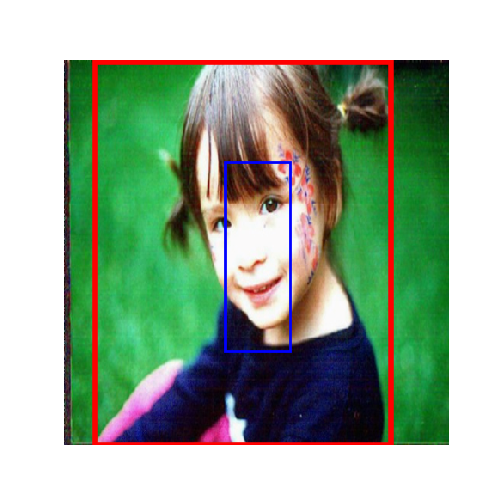

GT tensor(35.8400) tensor(1.3535) tensor(380.8000) tensor(448.) person
tensor(186.8262) tensor(118.4685) tensor(262.5554) tensor(338.0806) person tensor(0.7899)


In [52]:
fig, axs = plt.subplots(ncols=1, figsize=(5, 5))
for i in range(gt_bboxes.size()[0]):
    xmin, ymin, xmax, ymax = gt_bboxes[i][0], gt_bboxes[i][1], gt_bboxes[i][2], gt_bboxes[i][3]
    print ("GT",xmin, ymin, xmax, ymax, class_list[gt_labels[i]])
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=4,edgecolor='r',facecolor='none')
    axs.add_patch(rect)

    
    
for i in range(output_bboxes.size()[0]):
    xmin, ymin, xmax, ymax = output_bboxes[i,:4]
    t = output_class_idx[i]
    print (xmin, ymin, xmax, ymax, class_list[t], output_bboxes[i,4])
    color = color_list[t % len(color_list)]
    rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
    axs.add_patch(rect)
            
axs.axis('off')
axs.imshow(img_mod)


In [ ]:

for i in range(output_class_idx.size()[0]):
    t = output_class_idx[i]
        
    gt_same_class_idx = (gt_labels == t)
    gt_same_class_bboxes = gt_bboxes[gt_same_class_idx]

    if (gt_same_class_bboxes.size()[0] == 0):
        predictions[t].append((output_bboxes[i,4], 0))
        continue

    ious = cal_iou(output_bboxes[i,:4].view(1,-1), gt_same_class_bboxes)
    max_ious,_ = torch.max(ious, dim = 1)
    if max_ious > ious_threshold :
        predictions[t].append((output_bboxes[i,4], 1))
    else : 
        predictions[t].append((output_bboxes[i,4], 0))

In [ ]:
for i in range(len(class_dict)):
    gt_same_class_idx = (gt_labels == i)
    gt_same_class_bboxes = gt_bboxes[gt_same_class_idx]

    output_same_class_idx = (output_class_idx== i)
    output_same_class_bboxes = output_bboxes[output_same_class_idx]

    print (gt_same_class_bboxes.size(),output_same_class_bboxes[:,:4].size() )
    
    ious = cal_iou(output_same_class_bboxes[:,:4], gt_same_class_bboxes)
    
    max_ious = torch.max()
    print (ious.size())
    


In [ ]:
i=0
gt_same_class_idx = (gt_labels == i)
gt_same_class_bboxes = gt_bboxes[gt_same_class_idx]

output_same_class_idx = (output_class_idx== i)
output_same_class_bboxes = output_bboxes[output_same_class_idx]

print (gt_same_class_bboxes.size(),output_same_class_bboxes[:,:4].size() )
ious = cal_iou(output_same_class_bboxes[:,:4], gt_same_class_bboxes)
print (ious.size())

max_ious = torch.argmax(ious, dim = 0)
print (max_ious)
    


In [ ]:
print (gt_class_count)

# Calculating mAP

In [ ]:
i=0
predicion_class = predictions[i]

predicion_class = sorted(predictions[i], key=lambda pred: pred[0], reverse = True)

precisions =[]
recalls = []
TPs = 0 
GT_TPs = gt_class_count[0,0]
print( gt_class_count[0,0])
for idx, (confidence, TP) in enumerate(predicion_class):
    
    TPs += TP
    
    curr_precision = TPs*1.0/(idx+1)
    curr_recall = TPs*1.0/GT_TPs

    precisions.append(curr_precision)
    recalls.append(curr_recall)


In [ ]:
print (precisions[:10])
print (recalls[:10])

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))

axes.clear()
axes.plot(precisions, recalls,
             label="people")
axes.set_xlabel("recall")
axes.set_ylabel("precision")
plt.tight_layout()
fig.canvas.draw()

<IPython.core.display.Javascript object>


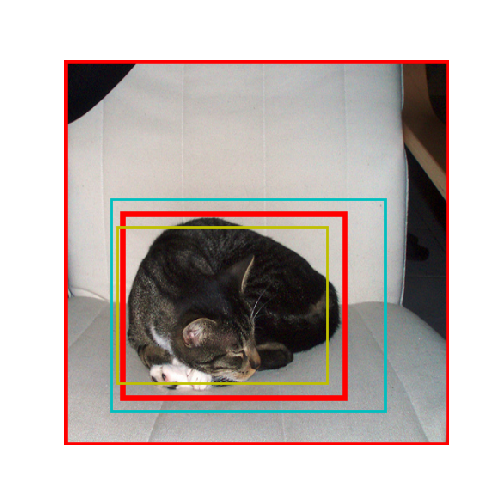

GT tensor(0.8960) tensor(1.1947) tensor(448.) tensor(448.) chair
GT tensor(68.9920) tensor(179.2000) tensor(327.0400) tensor(393.0453) cat
tensor(61.0531) tensor(193.9335) tensor(305.3780) tensor(375.2991) dog tensor(0.2696)
tensor(54.9287) tensor(161.8220) tensor(372.8333) tensor(407.7217) cat tensor(0.4649)


In [ ]:

def intersect(box_a, box_b):
    A = box_a.size(0)
    B = box_b.size(0)
    
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def cal_iou(box_a, box_b):
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]
